## Robot Demo!
----

Imports from each module:

In [1]:
import Modules.Control as Control
import matplotlib.pyplot as plt
import Modules.Path_planning as Path_planning
import tdmclient.notebook
import Modules.ThymioCommands as ThymioCommands
import Modules.LocalNav as LocalNav
import time
import cv2
import numpy as np
import Modules.Kalman as Kalman
from Modules.ThymioVision import ThymioVision # Computer vision package
from scipy.ndimage import distance_transform_edt

In [2]:
import tdmclient.notebook
import time
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.4375 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.4375 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega

@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right

def avoid_obstacle(vc, duration = 2, decision="right"):
    """
    Perform a simplified L-shaped maneuver for obstacle avoidance using time.sleep.
    Args:
        decision (str): Turning direction ("right" or "left").
    """
    print("Starting obstacle avoidance maneuver...")

    # Phase 1: Turn away from the obstacle
    print(f"Phase 1: Turning {decision} away from the obstacle.")
    curr_time = time.time()
    if decision == "right":
        set_speed(-100, 100)  # Turn right
    elif decision == "left":
        set_speed(100, -100)  # Turn left
    while time.time() - curr_time < duration:
        ret,frame = vc.read()
        if ret:
            cv2.imshow("Camera view", frame)
        key = cv2.waitKey(50)
    
    # Phase 2: Move forward to clear the obstacle
    curr_time = time.time()
    print("Phase 2: Moving forward to clear the obstacle.")
    set_speed(100, 100)  
    while time.time() - curr_time < duration+0.7:
        ret,frame = vc.read()
        if ret:
            cv2.imshow("Camera view", frame)
        key = cv2.waitKey(50)

    # Phase 3: Turn back to original direction
    curr_time = time.time()
    print(f"Phase 3: Returning to original direction (opposite of {decision}).")
    if decision == "right":
        set_speed(100, -100)  # Turn left
    elif decision == "left":
        set_speed(-100, 100)  # Turn right
    while time.time() - curr_time < duration:
        ret,frame = vc.read()
        if ret:
            cv2.imshow("Camera view", frame)
        cv2.waitKey(50)

    # Stop the robot
    stop_thymio()
    print("Obstacle avoidance completed.")


Begin the thymio, calibrate for demo

In [3]:
await tdmclient.notebook.start()

In [4]:
global leds_circle
leds_circle=[32,32,0,0,0,0,0,32] # Turn on thymio lights for tracking

In [ ]:
await tdmclient.notebook.stop()

Calibrate Camera, Detect Edges, Thymio Position, and Goal.

2024-12-05 12:33:56.440 Python[56174:2262355] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-12-05 12:33:57.638 Python[56174:2262355] +[IMKClient subclass]: chose IMKClient_Legacy
2024-12-05 12:33:57.638 Python[56174:2262355] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


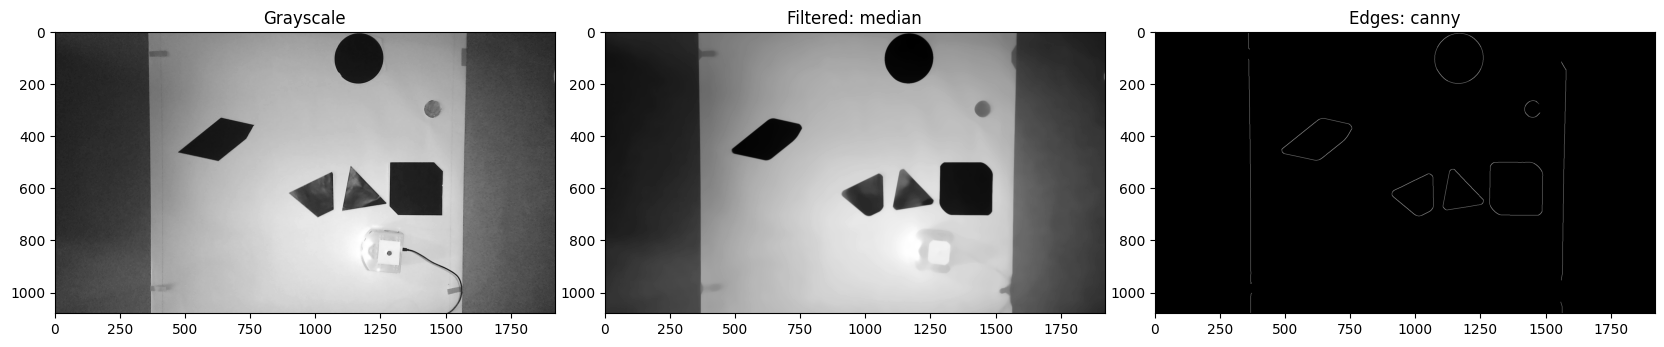

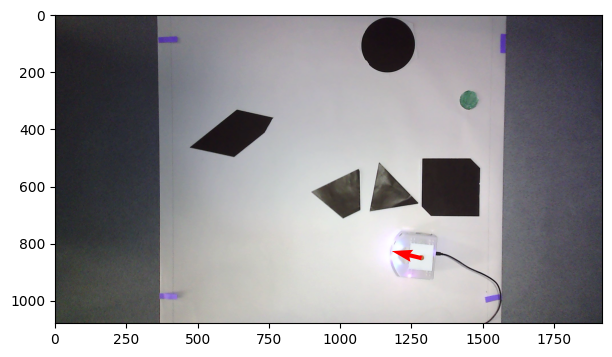

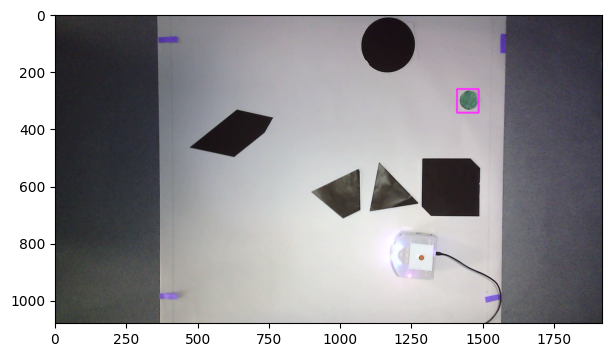

In [5]:
ThymioVision.calibrateCameraPos(0) #Calibrate the corners to the map.
frame = ThymioVision.captureImageOnCommand(0) # Capture the image to define the map
edges = ThymioVision.getEdges(frame, verbose=True)
start = ThymioVision.getThymioPose(frame, verbose=True)
end = ThymioVision.detectGoal(frame, verbose=True)

Display the map

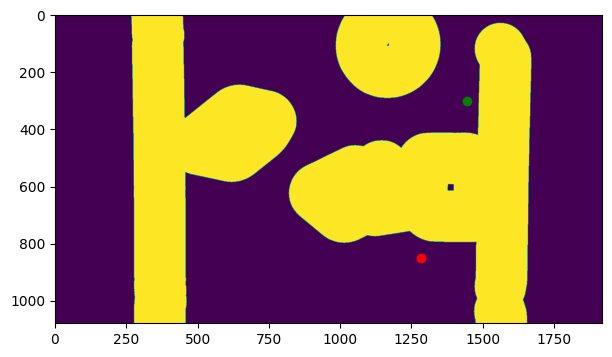

In [6]:
map = ThymioVision.getMap(frame, verbose=True)

Path found: [[851, 1285], [850, 1284], [850, 1283], [849, 1282], [848, 1281], [848, 1280], [848, 1279], [848, 1278], [848, 1277], [848, 1276], [848, 1275], [848, 1274], [848, 1273], [848, 1272], [848, 1271], [848, 1270], [848, 1269], [848, 1268], [848, 1267], [848, 1266], [848, 1265], [848, 1264], [848, 1263], [848, 1262], [848, 1261], [848, 1260], [848, 1259], [848, 1258], [848, 1257], [848, 1256], [848, 1255], [847, 1254], [846, 1253], [845, 1252], [844, 1251], [843, 1250], [842, 1249], [841, 1248], [840, 1247], [839, 1246], [838, 1245], [837, 1244], [836, 1243], [835, 1242], [834, 1241], [833, 1240], [832, 1239], [831, 1238], [830, 1237], [829, 1236], [828, 1235], [827, 1234], [826, 1233], [825, 1232], [825, 1231], [824, 1230], [823, 1229], [822, 1228], [821, 1227], [820, 1226], [819, 1225], [818, 1224], [817, 1223], [816, 1222], [815, 1221], [814, 1220], [813, 1219], [812, 1218], [811, 1217], [810, 1216], [809, 1215], [808, 1214], [807, 1213], [806, 1212], [805, 1211], [804, 1210],

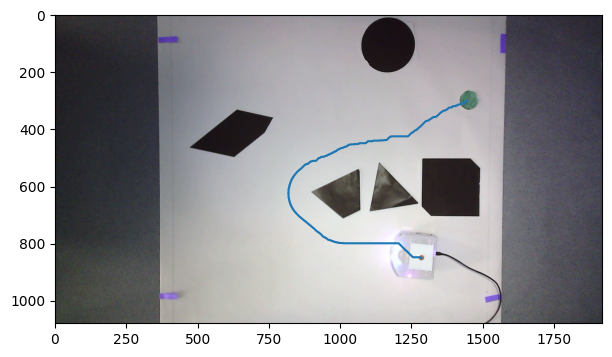

In [7]:
# Define the inputs for the path_planning module
obstacles = map[0]
start = map[1]
end = map[2]
# adjusting x/y to row/col -> flip them.
correctedStart = [start[1], start[0]]
correctedGoal = [end[1], end[0]]

# Determine best path from map
path = Path_planning.A_star(obstacles, correctedStart, correctedGoal)

# Break the path into waypoints that the Thymio can follow.
# Swap back to pixel coordinates
swapped = Path_planning.swap_path_coordinates(path)
waypoints = []
for point in swapped:
    x, y = ThymioVision.pixelToRealSpace(point)
    waypoints.append((x*10, y*10)) #convert to mm!
waypoints = Control.segment_path(waypoints, step=40)

lx = []
ly = []
for wp in path:
    lx.append(wp[0])
    ly.append(wp[1])

# Display path on frame
plt.imshow(frame)
plt.plot(ly, lx)
plt.show()

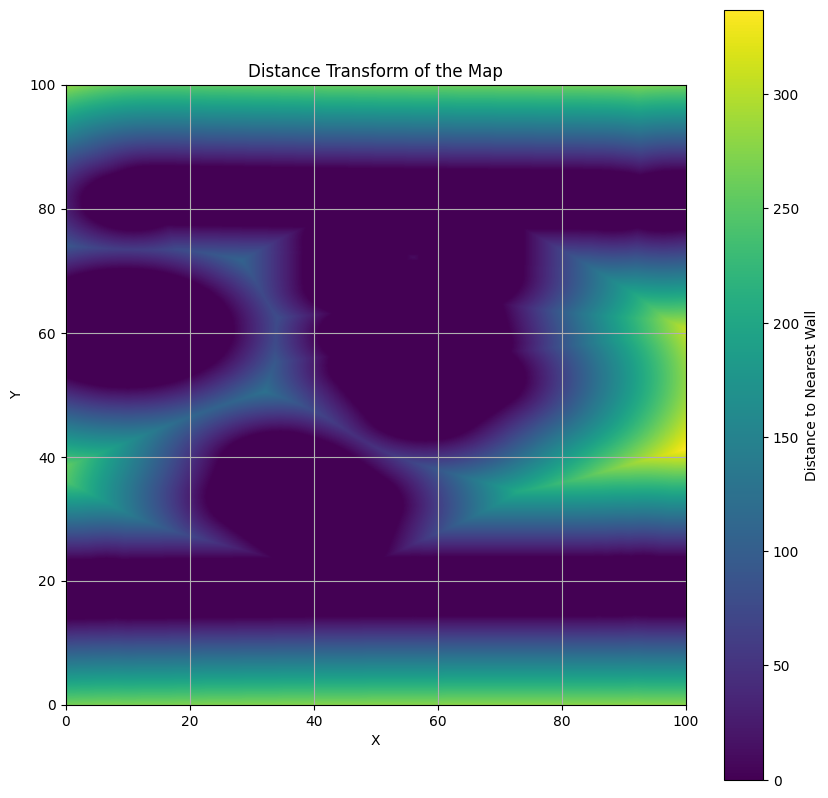

In [8]:
dist_map = distance_transform_edt(map[0] == 0)

flipped_dist_map = np.flipud(dist_map)

# Plot the distance transform
plt.figure(figsize=(10, 10))
plt.imshow(dist_map.T, origin='lower', cmap='viridis', extent=(0, 100, 0, 100))
plt.colorbar(label="Distance to Nearest Wall")
plt.title("Distance Transform of the Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

Main Movement Loop!

In [ ]:
import cv2

# BEGIN CAMERA CAPTURE
cv2.namedWindow("Camera view")
vc=cv2.VideoCapture(0)
print("vc captured")

###################### INITIALIZE STATE FROM MAP READ ######################

obstSpeedGain = [2, 1, -1, -1.5, -2.5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 8 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 35 # Threshold to start avoiding
OBSTACLE_THRESH_HIGH_SIDE = 40 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance, 2 = kidnapping
goal_tolerance = 30


state_est=[0,0,0,0,0] 
ret,frame=vc.read()
if ret:
    pose = ThymioVision.getThymioPose(frame) #pixel location of thymio
    obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
    obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
    state_est=[obs_camera[0],obs_camera[1],obs_camera[2],0,0]   
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])


###################### LOGGING DATA ######################
trajectory = []  # To store [x, y] positions
trajectory.append(obs_camera[0:2])
camera_trajectory = [] #trajectory mapped by camera
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal
time_prev = time.time()

###################### BEGIN MOTION LOOP ######################
while len(waypoints) > 0: # while we have goals in life
    actual_time = time.time()
    Ts = actual_time - time_prev
    if Ts < 0.15:
        time.sleep(0.15-Ts)
    time_prev = actual_time

    waypoint = waypoints[0] # current goal

    ################### SENSOR READS ###################
    ret,frame=vc.read()
    if ret:
        pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
        if pose[0] is not None:
            obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
            obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
            camera_trajectory.append(obs_camera) #position in mm appended to log
            arrowStart = pose[0:2]
            arrowEnd = (int(pose[0] + 50 * np.cos(pose[2])), int(pose[1] - 50 * np.sin(pose[2])))
            cv2.arrowedLine(frame, arrowStart, arrowEnd, color=(0,0,255), thickness=3) #camera pos
            for i in range(len(swapped)-1):
                cv2.line(frame, swapped[i], swapped[i+1], color=(255, 0 , 50), thickness=2)
            # convert trajectory onto map
        if len(trajectory) > 0:
            lastPos = trajectory[-1]
            lastPos = (lastPos[0]/10, lastPos[1]/10)
            pixelPred = ThymioVision.realSpaceToPixel(lastPos)
            cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
        cv2.imshow("Camera view", frame)
        key = cv2.waitKey(50)
    if key == ord('q'):
        break
    if not ret or pose[0] is None:
        camera_state=False
    else:
        camera_state=True
    print(camera_state)

    prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
    proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]

    ###################### CHECK THYMIO STATE ######################

    # Check for obstacle state transitions
    if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
        if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values[1:4]) or prox_right//100 > OBSTACLE_THRESH_HIGH_FRONT or prox_left//100 > OBSTACLE_THRESH_HIGH_FRONT:
            thymio_state = 1
        elif len(trajectory) >= 1 and ((obs_camera[0]-trajectory[-1][0])**2 + (obs_camera[1]-trajectory[-1][1])**2) > 500:
            print(obs_camera)
            print(trajectory[-1])
            # if change between states is too rapid, we have been kidnapped. recalculate and attempt again
            thymio_state = 2
            continue
    elif thymio_state == 1:
    # Switch back to goal tracking if obstacles are cleared
        if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
            print("Obstacle avoided")
            #set_speed(20, 20)  #Continue getting away from obstacle for a short time ?   
            #stop_thymio() #idk if i keep it 
            thymio_state = 2 # set state to "kidnapped." Will recalculate the path and continue.

    ###################### GLOBAL NAVIGATION ######################
    if thymio_state == 0:
        print("Global Nav")
        # input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance)
        # input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(obs_camera, waypoint, goal_tolerance)
        if not camera_state:
            input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance*2)
            set_speed(int(input_right_speed/2), int(input_left_speed/2))
        else:
            input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance)
            set_speed(input_right_speed, input_left_speed)
    ###################### LOCAL NAVIGATION ######################   
    elif thymio_state == 1:
        print("Avoidance")
        decision, left_dist, right_dist = LocalNav.check_sides(state_est[0:3], flipped_dist_map)
        print(f"Turning decision: {decision}, Left Distance: {left_dist}, Right Distance: {right_dist}")
        if not(prox_right//100 > OBSTACLE_THRESH_HIGH_SIDE) and not (prox_left//100 > OBSTACLE_THRESH_HIGH_SIDE):
            avoid_obstacle(vc=vc, duration=2, decision=decision)
        else:
            avoid_obstacle(vc=vc, duration=0.8, decision=decision)

    ###################### KIDNAPPING RECALCULATION ###################### 
    else:
        print("Kidnapped") ##TODO FIX NO PATH FOUND ERROR
        # stop the thymio
        input_left_speed, input_right_speed, reached , v_f , omega_f = 0, 0, False, 0, 0
        set_speed(input_right_speed, input_left_speed)
        #if the camera is reading, update the path
        if camera_state:
            # convert trajectory onto map
            if len(trajectory) > 0:
                lastPos = trajectory[-1]
                lastPos = (lastPos[0]/10, lastPos[1]/10)
                pixelPred = ThymioVision.realSpaceToPixel(lastPos)
                cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
            cv2.imshow("Camera view", frame)
            path = None
            while not path:
                ret,frame=vc.read()
                if ret:
                    pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
                    if pose[0] is not None:
                        path = Path_planning.A_star(obstacles, (pose[1],pose[0]), correctedGoal)
                    cv2.imshow("Camera view", frame)
            swapped = Path_planning.swap_path_coordinates(path)
            waypoints = []
            for point in swapped:
                x, y = ThymioVision.pixelToRealSpace(point)
                waypoints.append((x*10, y*10)) #convert to mm!
            waypoints = Control.segment_path(waypoints, step=40)
            trajectory.append(obs_camera[0:2]) #append most recent location
            thymio_state = 0 # go back to global nav

        
    ################### UPDATE STATE ESTIMATE ###################

    # Control input
    input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
    input_w = omega_f
    control_vect_prev = [input_v, input_w]
    
    r_speed_odo, l_speed_odo = get_speed()
    actual_v = speed_convesion(r_speed_odo, l_speed_odo)
    actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
    obs_odometry = [actual_v, actual_w]

    # Update state with Kalman filter
    state_est, P_est = Kalman.ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
    state_est[2]=Control.normalize_angle(state_est[2])
    # Log trajectory
    trajectory.append((state_est[0], state_est[1]))
    
    # Calculate and log metrics
    rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
    alpha = Control.normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
    metrics_rho.append(rho)
    metrics_alpha.append(alpha)
    
    # Print updated state
    # print(ThymioVision.pixelToRealSpace(pose[0:2]))
    print(f"Position Actuelle camera  : x = {obs_camera[0]}, y = {obs_camera[1]}, theta = {obs_camera[2]}") 
    print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 

    if reached:
        waypoints.pop(0)
        print(f"Reached waypoint: {waypoint}")
        # Stop the robot at the waypoint
        stop_thymio()

vc.release()
stop_thymio()
cv2.destroyAllWindows()
print("Trajectory completed!")


vc captured
True
Global Nav
Position Actuelle camera  : x = 693.75, y = 570.75, theta = 2.896613990462929
Position Actuelle odometry: x = 693.7500000315506, y = 570.7499999882812, theta = 2.895616986370637
Reached waypoint: (693.75, 570.75)
True
Global Nav
Position Actuelle camera  : x = 693.75, y = 570.75, theta = 2.827972001373095
Position Actuelle odometry: x = 693.7548040841139, y = 570.748774814724, theta = 2.833649884355106
True
Global Nav
Position Actuelle camera  : x = 693.75, y = 570.75, theta = 2.9127938082025677
Position Actuelle odometry: x = 693.7356004803657, y = 570.7541431555635, theta = 2.9058261337672366


2024-12-05 12:34:25.082 Python[56174:2262355] _TIPropertyValueIsValid called with 16 on nil context!
2024-12-05 12:34:25.082 Python[56174:2262355] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2024-12-05 12:34:25.082 Python[56174:2262355] Text input context does not respond to _valueForTIProperty:


True
Global Nav
Position Actuelle camera  : x = 690.75, y = 570.75, theta = 2.8488795783657963
Position Actuelle odometry: x = 690.7448156590117, y = 570.7641162832807, theta = 2.859256885455074
True
Global Nav
Position Actuelle camera  : x = 686.25, y = 570.75, theta = 2.8685839505030826
Position Actuelle odometry: x = 686.2413769949419, y = 570.771367543473, theta = 2.8751181586931605
Reached waypoint: (663.75, 561.0)
True
Global Nav
Position Actuelle camera  : x = 681.75, y = 569.25, theta = 2.9026562130036297
Position Actuelle odometry: x = 681.780697698652, y = 569.2972665422869, theta = 2.916222343384522
True
Global Nav
Position Actuelle camera  : x = 678.75, y = 569.25, theta = 2.784283970581693
Position Actuelle odometry: x = 678.7447674642433, y = 569.2632828205225, theta = 2.7998404293752435
True
Global Nav
Position Actuelle camera  : x = 675.75, y = 567.75, theta = 2.7917370517326954
Position Actuelle odometry: x = 675.7374472437217, y = 567.7837844915393, theta = 2.80973363

2024-12-05 12:34:26.275 Python[56174:2262355] _TIPropertyValueIsValid called with 16 on nil context!
2024-12-05 12:34:26.276 Python[56174:2262355] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2024-12-05 12:34:26.276 Python[56174:2262355] Text input context does not respond to _valueForTIProperty:


True
Global Nav
Position Actuelle camera  : x = 671.25, y = 567.75, theta = 2.646040980103965
Position Actuelle odometry: x = 671.2468526012958, y = 567.7719697810999, theta = 2.6730313028000126
True
Global Nav
Position Actuelle camera  : x = 663.75, y = 564.75, theta = 2.649381386750227
Position Actuelle odometry: x = 663.7587010443074, y = 564.8011908945372, theta = 2.689922234248839
True
Global Nav
Position Actuelle camera  : x = 657.75, y = 563.25, theta = 2.5679259854216325
Position Actuelle odometry: x = 657.7609788902787, y = 563.3002210159593, theta = 2.6071464643413416
True
Global Nav
Position Actuelle camera  : x = 651.75, y = 560.25, theta = 2.5636907166275478
Position Actuelle odometry: x = 651.7636604866484, y = 560.3139321339474, theta = 2.605429254087845
True
Global Nav
Position Actuelle camera  : x = 647.25, y = 558.75, theta = 2.4707351869890264
Position Actuelle odometry: x = 647.2684296791714, y = 558.8046468776074, theta = 2.5090351817951353
True
Global Nav
Position

: 

In [ ]:
stop_thymio()